In [54]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import tensorflow

# Random Forest model
def create_random_forest():
    return RandomForestRegressor()

# XG-Boost model
def create_xgboost():
    return XGBRegressor()

# LSTM model
def create_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [55]:
import pandas as pd

data_lkoh = pd.read_csv('data/Прошлые данные - LKOH.csv')

# Убираем суффиксы "K" из столбца "Объём"
data_lkoh['Объём'] = data_lkoh['Объём'].str.replace('M', '000000').str.replace('K', '000')

data_lkoh['Изм. %'] = data_lkoh['Изм. %'].str.replace('%', '')

# Преобразование типов данных с учетом разделителей тысяч и возможных десятичных запятых
data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])
data_lkoh['Цена'] = pd.to_numeric(data_lkoh['Цена'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Откр.'] = pd.to_numeric(data_lkoh['Откр.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Макс.'] = pd.to_numeric(data_lkoh['Макс.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Мин.'] = pd.to_numeric(data_lkoh['Мин.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Объём'] = pd.to_numeric(data_lkoh['Объём'].str.replace('.', '').str.replace(',', ''))
data_lkoh['Изм. %'] = pd.to_numeric(data_lkoh['Изм. %'].str.replace(',', '.'))


C:\Users\User\AppData\Local\Temp\ipykernel_15512\2200322504.py:11: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])


In [64]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np

# Assume X_train, X_val, y_train, y_val are your data and labels
X_train= data_lkoh.drop(['Цена'], axis=1)  # Признаки
y_train = data_lkoh['Цена']  # Целевая переменная
# Split the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [60]:

# Create the base models
random_forest_model = RandomForestRegressor()
xgboost_model = XGBRegressor()
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the base models
random_forest_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lstm_model.fit(X_train, y_train, epochs=5, batch_size=10)

# Make predictions with the base models
random_forest_preds = random_forest_model.predict(X_val)
xgboost_preds = xgboost_model.predict(X_val)
lstm_preds = lstm_model.predict(X_val)

# Combine the predictions as features
ensemble_features = np.column_stack((random_forest_preds, xgboost_preds, lstm_preds))

# Train the XGBoost model using the ensemble features
xgboost_ensemble_model = XGBRegressor()
xgboost_ensemble_model.fit(ensemble_features, y_val)

ModuleNotFoundError: No module named 'seaborn'

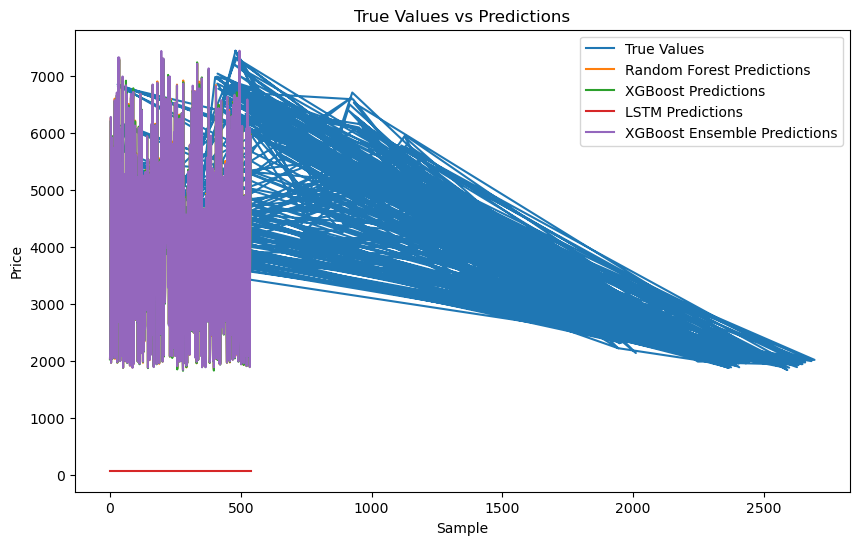

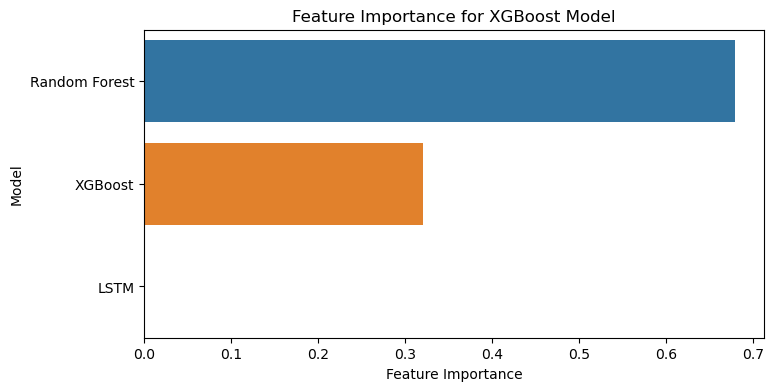

Random Forest R^2: 0.9994851826369517
Random Forest RMSE: 35.49625916698433
XGBoost R^2: 0.9995138762033243
XGBoost RMSE: 34.49287815589316
LSTM R^2: -6.37867903689333
LSTM RMSE: 4249.573092413788
XGBoost Ensemble R^2: 0.9999910062149541
XGBoost Ensemble RMSE: 4.691667711552956


In [62]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate R^2 score for each model
random_forest_r2 = r2_score(y_val, random_forest_preds)
xgboost_r2 = r2_score(y_val, xgboost_preds)
lstm_r2 = r2_score(y_val, lstm_preds)
xgboost_ensemble_r2 = xgboost_ensemble_model.score(ensemble_features, y_val)

# Calculate RMSE for each model
random_forest_rmse = np.sqrt(mean_squared_error(y_val, random_forest_preds))
xgboost_rmse = np.sqrt(mean_squared_error(y_val, xgboost_preds))
lstm_rmse = np.sqrt(mean_squared_error(y_val, lstm_preds))
xgboost_ensemble_rmse = np.sqrt(mean_squared_error(y_val, xgboost_ensemble_model.predict(ensemble_features)))

# Plot the true values and predictions for each model
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True Values')
plt.plot(random_forest_preds, label='Random Forest Predictions')
plt.plot(xgboost_preds, label='XGBoost Predictions')
plt.plot(lstm_preds, label='LSTM Predictions')
plt.plot(xgboost_ensemble_model.predict(ensemble_features), label='XGBoost Ensemble Predictions')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()

# Plot feature importance for XGBoost model
feature_importance = xgboost_ensemble_model.feature_importances_
feature_names = ['Random Forest', 'XGBoost', 'LSTM']
plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importance, y=feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Model')
plt.title('Feature Importance for XGBoost Model')
plt.show()

# Print the R^2 scores and RMSE for each model
print('Random Forest R^2:', random_forest_r2)
print('Random Forest RMSE:', random_forest_rmse)
print('XGBoost R^2:', xgboost_r2)
print('XGBoost RMSE:', xgboost_rmse)
print('LSTM R^2:', lstm_r2)
print('LSTM RMSE:', lstm_rmse)
print('XGBoost Ensemble R^2:', xgboost_ensemble_r2)
print('XGBoost Ensemble RMSE:', xgboost_ensemble_rmse)

In [ ]:
import matplotlib.pyplot as plt

# Создание DataFrame для удобства визуализации


# Нарисуем график
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], label='Actual Price', color='blue')
plt.plot(results['Date'], results['Predicted'], label='Predicted Price', color='red')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

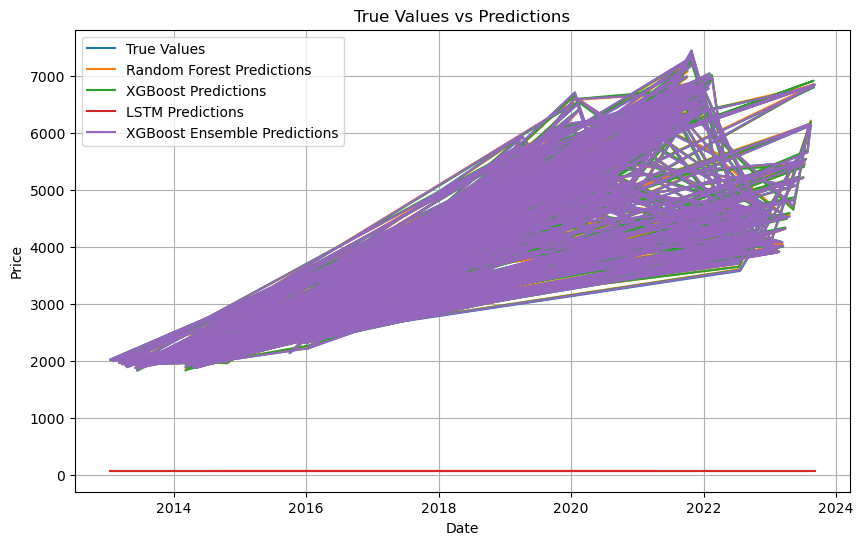

In [75]:
import pandas as pd

# Convert the date column to datetime format
data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])

# Create a new dataframe with the predictions and actual values
predictions_df = pd.DataFrame({
    'Date': X_val['Дата'].values.flatten(),
    'True Values': y_val.values.flatten(),
    'Random Forest Predictions': random_forest_preds.flatten(),
    'XGBoost Predictions': xgboost_preds.flatten(),
    'LSTM Predictions': lstm_preds.flatten(),
    'XGBoost Ensemble Predictions': xgboost_ensemble_model.predict(ensemble_features).flatten()
})

# Plot the true values and predictions for each model
plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['True Values'], label='True Values')
plt.plot(predictions_df['Date'], predictions_df['Random Forest Predictions'], label='Random Forest Predictions')
plt.plot(predictions_df['Date'], predictions_df['XGBoost Predictions'], label='XGBoost Predictions')
plt.plot(predictions_df['Date'], predictions_df['LSTM Predictions'], label='LSTM Predictions')
plt.plot(predictions_df['Date'], predictions_df['XGBoost Ensemble Predictions'], label='XGBoost Ensemble Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('True Values vs Predictions')
plt.legend()
plt.grid(True)

plt.show()

In [79]:
predictions_df

,Date,True Values,Random Forest Predictions,XGBoost Predictions,LSTM Predictions,XGBoost Ensemble Predictions
0,2014-09-02,2042.1,2038.841,2028.689575,75.957703,2042.036865
1,2014-11-28,2291.7,2304.184,2305.191406,75.957680,2293.692627
2,2022-04-29,4699.5,4615.435,4681.176758,75.957794,4700.813477
3,2021-08-09,6290.0,6265.265,6213.508301,75.957733,6280.264160
4,2014-02-05,1965.0,1970.287,1973.217163,75.957672,1967.035522
...,...,...,...,...,...,...
534,2013-04-18,1892.8,1905.013,1901.558105,75.957657,1892.046997
535,2016-12-21,3439.0,3435.430,3468.888428,75.957733,3443.249023
536,2022-05-26,4263.0,4196.275,4267.801758,75.957802,4262.205078
537,2022-12-19,4625.0,4603.585,4617.442383,75.957741,4625.324219


In [50]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Get predictions for each model
random_forest_preds = random_forest_model.predict(X_val)
xgboost_preds = xgboost_model.predict(X_val)
lstm_preds = lstm_model.predict(X_val)
# ensemble_preds = ensemble_model.predict(X_val)

# Calculate r^2 score for each model
random_forest_r2 = r2_score(y_val, random_forest_preds)
xgboost_r2 = r2_score(y_val, xgboost_preds)
lstm_r2 = r2_score(y_val, lstm_preds)
# ensemble_r2 = r2_score(y_val, ensemble_preds)

# Calculate MAE for each model
random_forest_mae = mean_absolute_error(y_val, random_forest_preds)
xgboost_mae = mean_absolute_error(y_val, xgboost_preds)
lstm_mae = mean_absolute_error(y_val, lstm_preds)
# ensemble_mae = mean_absolute_error(y_val, ensemble_preds)

# Calculate RMSE for each model
random_forest_rmse = mean_squared_error(y_val, random_forest_preds, squared=False)
xgboost_rmse = mean_squared_error(y_val, xgboost_preds, squared=False)
lstm_rmse = mean_squared_error(y_val, lstm_preds, squared=False)
# ensemble_rmse = mean_squared_error(y_val, ensemble_preds, squared=False)

# ensemble_mape = calculate_mape(y_val, ensemble_preds)

# Print the results
print("Random Forest:")
print("r^2:", random_forest_r2)
print("MAE:", random_forest_mae)
print("RMSE:", random_forest_rmse)

print("XGBoost:")
print("r^2:", xgboost_r2)
print("MAE:", xgboost_mae)
print("RMSE:", xgboost_rmse)

print("LSTM:")
print("r^2:", lstm_r2)
print("MAE:", lstm_mae)
print("RMSE:", lstm_rmse)

# print("Ensemble:")
# print("r^2:", ensemble_r2)
# print("MAE:", ensemble_mae)
# print("RMSE:", ensemble_rmse)
# print("MAPE:", ensemble_mape)

17/17 [==============================] - 1s 2ms/step
Random Forest:
r^2: 0.9994987748265921
MAE: 21.116679035250428
RMSE: 35.02453927334136
XGBoost:
r^2: 0.9995138762033243
MAE: 22.23550542997739
RMSE: 34.49287815589316
LSTM:
r^2: -3.798221020761372
MAE: 3048.9205705009276
RMSE: 3426.8580746785283


In [21]:
# Сброс индексов для X_train и y_train
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

ensemble_model.fit(X_train, y_train )


ValueError: The estimator Sequential should be a regressor.

In [52]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Create the base models
random_forest_model = RandomForestRegressor()
xgboost_model = XGBRegressor()
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))

# Train the base models
random_forest_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lstm_model.fit(X_train, y_train)

# Make predictions with the base models
random_forest_preds = random_forest_model.predict(X_test)
xgboost_preds = xgboost_model.predict(X_test)
lstm_preds = lstm_model.predict(X_test)

# Combine the predictions as features
ensemble_features = np.column_stack((random_forest_preds, xgboost_preds, lstm_preds))

# Train the XGBoost model using the ensemble features
xgboost_ensemble_model = XGBRegressor()
xgboost_ensemble_model.fit(ensemble_features, y_test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [15]:
y_train

0       3797.0
1       2870.0
2       2529.0
3       5626.0
4       1948.8
         ...  
2150    3003.0
2151    5300.0
2152    5894.0
2153    4479.0
2154    4745.5
Name: Цена, Length: 2155, dtype: float64

In [ ]:
# Display feature importance as a bar plot
feature_importance = model.feature_importances_
feature_names = X.columns

plt.bar(feature_names, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

# Plot the actual price and predicted price
plt.plot(y_test, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')


plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Функция для расчета скользящих средних
def calculate_moving_averages(data, window):
    data['SMA_' + str(window)] = data['Цена'].rolling(window=window).mean()  # Простое скользящее среднее
    data['EMA_' + str(window)] = data['Цена'].ewm(span=window, adjust=False).mean()  # Экспоненциальное скользящее среднее
    return data

# Функция для расчета RSI
def calculate_rsi(data, window=14):
    delta = data['Цена'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

# Функция для расчета MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Цена'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Цена'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data


# Загрузка данных
data_lkoh = pd.read_csv('data/Прошлые данные - LKOH.csv')


# Убираем суффиксы "K" из столбца "Объём"
data_lkoh['Объём'] = data_lkoh['Объём'].str.replace('M', '000000').str.replace('K', '000')
data_lkoh['Изм. %'] = data_lkoh['Изм. %'].str.replace('%', '')
# Преобразование типов данных с учетом разделителей тысяч и возможных десятичных запятых
data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])
data_lkoh['Цена'] = pd.to_numeric(data_lkoh['Цена'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Откр.'] = pd.to_numeric(data_lkoh['Откр.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Макс.'] = pd.to_numeric(data_lkoh['Макс.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Мин.'] = pd.to_numeric(data_lkoh['Мин.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Объём'] = pd.to_numeric(data_lkoh['Объём'].str.replace('.', '').str.replace(',', ''))
data_lkoh['Изм. %'] = pd.to_numeric(data_lkoh['Изм. %'].str.replace(',', '.'))

# Расчет признаков
data_lkoh = calculate_moving_averages(data_lkoh, window=20)  # Пример: 20-дневные скользящие средние
data_lkoh = calculate_rsi(data_lkoh)
data_lkoh = calculate_macd(data_lkoh)


# Interpolate missing values for 'RSI' and 'SMA_20' columns
data_lkoh['RSI'].interpolate(inplace=True)
data_lkoh['SMA_20'].interpolate(inplace=True)

# Check for remaining missing values
missing_values = data_lkoh.isnull().sum()
missing_values

# Выберите начальную дату (например, первая дата в вашем наборе данных)
start_date = data_lkoh['Дата'].min()

# Рассчитайте количество дней от начальной даты для каждой строки
data_lkoh['timestamp'] = (data_lkoh['Дата'] - start_date).dt.days

data_lkoh = data_lkoh.dropna()

# Подготовка данных для XGBoost
X = data_lkoh.drop(['Цена', 'Дата'], axis=1)  # Признаки
y = data_lkoh['Цена']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(data_lkoh) * 0.4)
X_test,X_train = X[:train_size], X[train_size:]
y_test,y_train = y[:train_size], y[train_size:]

# Создание и обучение модели XGBoost
model = xgb.XGBRegressor(max_depth=30, n_estimators=30)  # Подберите параметры по необходимости
model.fit(X_train, y_train)

# Прогнозирование
predictions = model.predict(X_test)

# Рассчет метрик
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)
# Prepare data for LSTM
data_lkoh = data_lkoh.dropna()
# X = data_lkoh.drop(['Цена', 'Дата'], axis=1)  # Features
# y = data_lkoh['Цена']  # Target variable

# Scale the input data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(data_lkoh['Цена'].values.reshape(-1, 1))


# Create sliding window of data points
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), :]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, :])
    return np.array(dataX), np.array(dataY)

time_steps = 10
X_train, y_train = create_dataset(X_scaled[train_size:], time_steps)
X_test, y_test = create_dataset(X_scaled[:train_size], time_steps)

# Create and train the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(25))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Make predictions using the trained model
predictions = model.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)


predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)


In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), :]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, :])
    return np.array(dataX), np.array(dataY)
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['Объём'] = data['Объём'].str.replace('M', '000000').str.replace('K', '000')
    data['Изм. %'] = data['Изм. %'].str.replace('%', '')
    data['Дата'] = pd.to_datetime(data['Дата'])
    data['Цена'] = pd.to_numeric(data['Цена'].str.replace('.', '').str.replace(',', '.'))
    data['Откр.'] = pd.to_numeric(data['Откр.'].str.replace('.', '').str.replace(',', '.'))
    data['Макс.'] = pd.to_numeric(data['Макс.'].str.replace('.', '').str.replace(',', '.'))
    data['Мин.'] = pd.to_numeric(data['Мин.'].str.replace('.', '').str.replace(',', '.'))
    data['Объём'] = pd.to_numeric(data['Объём'].str.replace('.', '').str.replace(',', ''))
    data['Изм. %'] = pd.to_numeric(data['Изм. %'].str.replace(',', '.'))
    return data

def calculate_moving_averages(data, window):
    data['SMA_' + str(window)] = data['Цена'].rolling(window=window).mean()
    data['EMA_' + str(window)] = data['Цена'].ewm(span=window, adjust=False).mean()
    return data

def calculate_rsi(data, window=14):
    delta = data['Цена'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Цена'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Цена'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

def preprocess_data(data):
    data = calculate_moving_averages(data, window=20)
    data = calculate_rsi(data)
    data = calculate_macd(data)
    data['RSI'].interpolate(inplace=True)
    data['SMA_20'].interpolate(inplace=True)
    return data

def train_xgboost_model(data):
    X = data.drop(['Цена', 'Дата'], axis=1)
    y = data['Цена']
    train_size = int(len(data) * 0.4)
    X_test, X_train = X[:train_size], X[train_size:]
    y_test, y_train = y[:train_size], y[train_size:]
    model = xgb.XGBRegressor(max_depth=30, n_estimators=30)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return model, rmse, r2

def train_lstm_model(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(data['Цена'].values.reshape(-1, 1))
    train_size = int(len(data) * 0.4)
    time_steps = 10
    X_train, y_train = create_dataset(X_scaled[train_size:], time_steps)
    X_test, y_test = create_dataset(X_scaled[:train_size], time_steps)
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return model, rmse, r2

def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), :]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, :])
    return np.array(dataX), np.array(dataY)

def plot_price_predictions(actual_prices, predicted_prices):
    plt.plot(actual_prices, label='Actual Price')
    plt.plot(predicted_prices, label='Predicted Price')
    plt.title('Actual Price vs Predicted Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_15512\1007868830.py:26: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Дата'] = pd.to_datetime(data['Дата'])
C:\Users\User\AppData\Local\Temp\ipykernel_15512\1007868830.py:26: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Дата'] = pd.to_datetime(data['Дата'])
C:\Users\User\AppData\Local\Temp\ipykernel_15512\1007868830.py:26: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Дата'] = pd.to_datetime(data['Дата'])
C:\Users\User\AppData\Local\Temp\ipykernel_15512\1007868830.py:26: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=T


Processing data for LKOH...

Training XGBoost model for LKOH...
RMSE (Root Mean Squared Error): 427.98961810703753
R2 Score: 0.8014806906120514


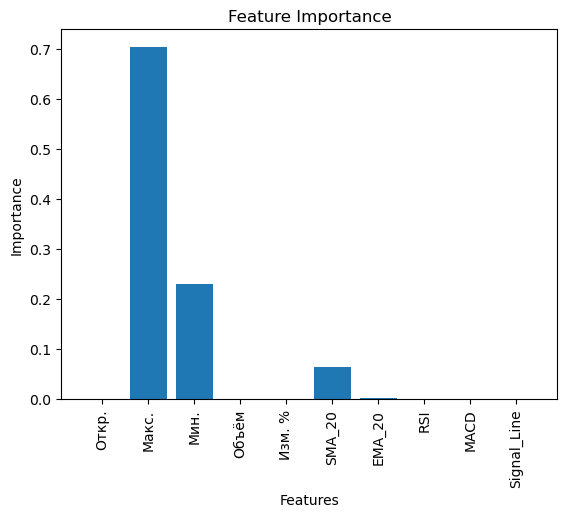


Preparing data for LSTM for LKOH...

Creating and training LSTM model for LKOH...
Epoch 1/10
101/101 [==============================] - 5s 12ms/step - loss: 0.0272 - val_loss: 0.0112
Epoch 2/10
101/101 [==============================] - 1s 5ms/step - loss: 2.5876e-04 - val_loss: 0.0012
Epoch 3/10
101/101 [==============================] - 1s 5ms/step - loss: 1.0794e-04 - val_loss: 0.0011
Epoch 4/10
101/101 [==============================] - 1s 5ms/step - loss: 9.8889e-05 - val_loss: 0.0011
Epoch 5/10
101/101 [==============================] - 1s 5ms/step - loss: 1.0577e-04 - val_loss: 6.8745e-04
Epoch 6/10
101/101 [==============================] - 1s 5ms/step - loss: 9.0693e-05 - val_loss: 7.4162e-04
Epoch 7/10
101/101 [==============================] - 1s 6ms/step - loss: 8.7547e-05 - val_loss: 5.5773e-04
Epoch 8/10
101/101 [==============================] - 1s 6ms/step - loss: 8.6738e-05 - val_loss: 5.8747e-04
Epoch 9/10
101/101 [==============================] - 1s 5ms/step - loss

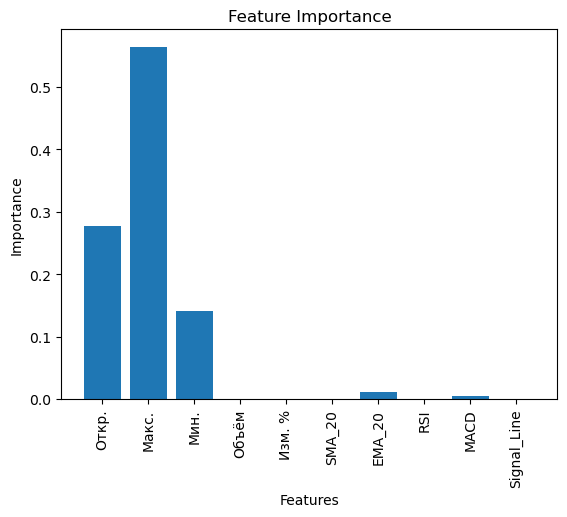


Preparing data for LSTM for INGR...

Creating and training LSTM model for INGR...
Epoch 1/10
100/100 [==============================] - 8s 12ms/step - loss: 0.0168 - val_loss: 0.0028
Epoch 2/10
100/100 [==============================] - 1s 6ms/step - loss: 9.3301e-05 - val_loss: 0.0021
Epoch 3/10
100/100 [==============================] - 1s 6ms/step - loss: 5.8007e-05 - val_loss: 0.0019
Epoch 4/10
100/100 [==============================] - 1s 5ms/step - loss: 6.0560e-05 - val_loss: 0.0019
Epoch 5/10
100/100 [==============================] - 1s 5ms/step - loss: 6.1374e-05 - val_loss: 0.0017
Epoch 6/10
100/100 [==============================] - 1s 5ms/step - loss: 6.7721e-05 - val_loss: 0.0018
Epoch 7/10
100/100 [==============================] - 1s 5ms/step - loss: 6.5959e-05 - val_loss: 0.0016
Epoch 8/10
100/100 [==============================] - 1s 5ms/step - loss: 6.6767e-05 - val_loss: 0.0013
Epoch 9/10
100/100 [==============================] - 1s 5ms/step - loss: 6.2842e-05 - v

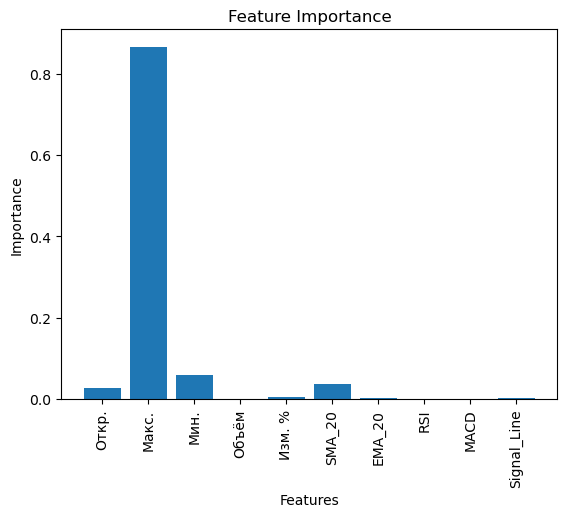


Preparing data for LSTM for LENT...

Creating and training LSTM model for LENT...
Epoch 1/10
16/16 [==============================] - 4s 51ms/step - loss: 0.0642 - val_loss: 0.0038
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0264 - val_loss: 0.0109
Epoch 3/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0224 - val_loss: 0.0057
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0198 - val_loss: 0.0051
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0169 - val_loss: 0.0033
Epoch 6/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0037
Epoch 7/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0023
Epoch 8/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 4.9127e-04
Epoch 9/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 2.6345e-04
Epoch 10/10
16/16 [=======

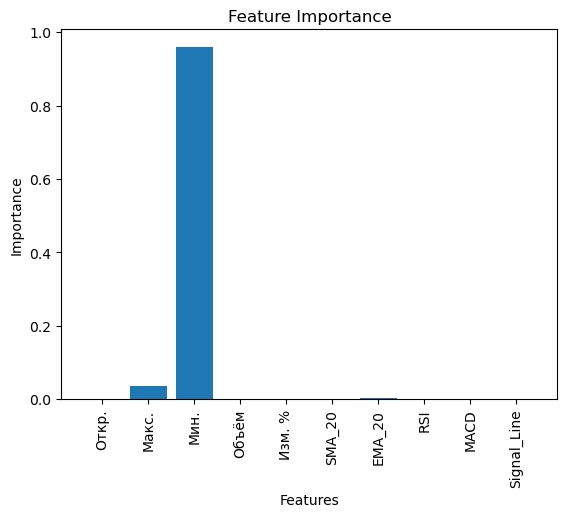


Preparing data for LSTM for LSRG...

Creating and training LSTM model for LSRG...
Epoch 1/10
101/101 [==============================] - 5s 12ms/step - loss: 0.0643 - val_loss: 0.0208
Epoch 2/10
101/101 [==============================] - 1s 6ms/step - loss: 0.0061 - val_loss: 9.9589e-04
Epoch 3/10
 37/101 [=========>....................] - ETA: 0s - loss: 5.7937e-04


KeyboardInterrupt



In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), :]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, :])
    return np.array(dataX), np.array(dataY)
# Функция для загрузки данных
def load_data(stock_symbol):
    filename = f'data/Прошлые данные - {stock_symbol}.csv'
    data = pd.read_csv(filename)
    return data

# Функция для обработки данных
def process_data(data):
    data['Объём'] = data['Объём'].str.replace('M', '000000').str.replace('K', '000')
    data['Изм. %'] = data['Изм. %'].str.replace('%', '')
    data['Дата'] = pd.to_datetime(data['Дата'])
    data['Цена'] = pd.to_numeric(data['Цена'].str.replace('.', '').str.replace(',', '.'))
    data['Откр.'] = pd.to_numeric(data['Откр.'].str.replace('.', '').str.replace(',', '.'))
    data['Макс.'] = pd.to_numeric(data['Макс.'].str.replace('.', '').str.replace(',', '.'))
    data['Мин.'] = pd.to_numeric(data['Мин.'].str.replace('.', '').str.replace(',', '.'))
    data['Объём'] = pd.to_numeric(data['Объём'].str.replace('.', '').str.replace(',', ''))
    data['Изм. %'] = pd.to_numeric(data['Изм. %'].str.replace(',', '.'))
    return data

# Функция для расчета скользящих средних
def calculate_moving_averages(data, window):
    data[f'SMA_{window}'] = data['Цена'].rolling(window=window).mean()
    data[f'EMA_{window}'] = data['Цена'].ewm(span=window, adjust=False).mean()
    return data

# Функция для расчета RSI
def calculate_rsi(data, window=14):
    delta = data['Цена'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

# Функция для расчета MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Цена'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Цена'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

# Функция для интерполяции пропущенных значений
def interpolate_missing_values(data):
    data['RSI'].interpolate(inplace=True)
    data['SMA_20'].interpolate(inplace=True)
    return data

# Функция для подготовки данных для XGBoost
def prepare_data_xgboost(data):
    X = data.drop(['Цена', 'Дата'], axis=1)
    y = data['Цена']
    return X, y

# Функция для обучения модели XGBoost
def train_xgboost_model(X_train, y_train):
    model = xgb.XGBRegressor(max_depth=30, n_estimators=30)
    model.fit(X_train, y_train)
    return model

# Функция для оценки модели XGBoost и отображения важности признаков
def evaluate_xgboost_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    print('RMSE (Root Mean Squared Error):', rmse)
    print('R2 Score:', r2)

    feature_importance = model.feature_importances_
    feature_names = X_test.columns
    plt.bar(feature_names, feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=90)
    plt.show()

# Функция для обработки данных для LSTM
def prepare_data_lstm(data, train_size=0.4, time_steps=1):
    data = data.dropna()
    X = data.drop(['Цена', 'Дата'], axis=1)
    y = data['Цена']

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(data['Цена'].values.reshape(-1, 1))

    train_size = int(len(data) * train_size)
    X_train, y_train = create_dataset(X_scaled[train_size:], time_steps)
    X_test, y_test = create_dataset(X_scaled[:train_size], time_steps)

    return X_train, y_train, X_test, y_test, scaler

# Функция для создания модели LSTM
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Функция для обучения модели LSTM
def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=16):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    return model, history

# Функция для предсказания с использованием модели LSTM
def predict_lstm(model, X_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    return predictions

# Функция для оценки модели LSTM и отображения результатов
def evaluate_lstm_model(y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    print('RMSE (Root Mean Squared Error):', rmse)
    print('R2 Score:', r2)

# Основная функция для обработки данных для 12 акций
def process_data_for_multiple_stocks(stock_symbols):
    data_frames = {}
    for symbol in stock_symbols:
        data = load_data(symbol)
        data = process_data(data)
        data = calculate_moving_averages(data, window=20)
        data = calculate_rsi(data)
        data = calculate_macd(data)
        data = interpolate_missing_values(data)
        data_frames[symbol] = data
    return data_frames

# Основная функция для обучения и оценки моделей для 12 акций
def train_and_evaluate_models(data_frames):
    for symbol, data in data_frames.items():
        print(f"\nProcessing data for {symbol}...")
        X, y = prepare_data_xgboost(data)
        train_size = int(len(data) * 0.4)
        X_test, X_train = X[:train_size], X[train_size:]
        y_test, y_train = y[:train_size], y[train_size:]

        print(f"\nTraining XGBoost model for {symbol}...")
        xgb_model = train_xgboost_model(X_train, y_train)
        evaluate_xgboost_model(xgb_model, X_test, y_test)

        print(f"\nPreparing data for LSTM for {symbol}...")
        X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, scaler = prepare_data_lstm(data)

        print(f"\nCreating and training LSTM model for {symbol}...")
        lstm_model = create_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
        lstm_model, history = train_lstm_model(lstm_model, X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)

        print(f"\nPredicting using LSTM model for {symbol}...")
        predictions_lstm = predict_lstm(lstm_model, X_test_lstm, scaler)

        print(f"\nEvaluating LSTM model for {symbol}...")
        evaluate_lstm_model(y_test_lstm, predictions_lstm)

# Список символов акций
stock_symbols = ['LKOH', 'INGR', 'LENT', 'LSRG', 'MVID', 'NVTK', 'OZONDR', 'PIKK', 'ROSN', 'FIVEDR', 'SMLT', 'GAZP (3)']

# Обработка данных для 12 акций
data_frames = process_data_for_multiple_stocks(stock_symbols)

# Обучение и оценка моделей для 12 акций
train_and_evaluate_models(data_frames)
